This example notebook uses the averaging functions found ins the diff_classifier msd module to find average msd profiles over input msd datasets using precision-weighted averaging. Precision is the inverse of the standard squared error. This increases the contribution of videos that have many particles and more homogeneous datasets to the final calculated MSD.

In [1]:
import numpy as np
import diff_classifier.aws as aws
import diff_classifier.msd as msd

In [2]:
to_track = []
result_futures = {}
start_knot = 31 #Must be unique number for every run on Cloudknot.

frames = 651
fps = 100.02
umppx = 0.07

folder = '9_28_18_Gel_Interface_Vids' #Folder in AWS S3 containing files to be analyzed
bucket = 'mckenna.data'
vids = 5
combos = [['0_4', '0_6'], ['0_4', '0_8'], ['0_4', '1_2'], ['0_6', '0_8'], ['0_8', '1_0'], ['1_0', '1_2']]

for combo in combos:
    for gel in combo:
        for num in range(1, vids+1):
            #to_track.append('100x_0_4_1_2_gel_{}_bulk_vid_{}'.format(vis, num))
            to_track.append('100x_{}_{}_gel_{}_bulk_vid_{}'.format(combo[0], combo[1], gel, num))

In [13]:
to_track[5:10] + to_track[30:35]

['100x_0_4_0_6_gel_0_6_bulk_vid_1',
 '100x_0_4_0_6_gel_0_6_bulk_vid_2',
 '100x_0_4_0_6_gel_0_6_bulk_vid_3',
 '100x_0_4_0_6_gel_0_6_bulk_vid_4',
 '100x_0_4_0_6_gel_0_6_bulk_vid_5',
 '100x_0_6_0_8_gel_0_6_bulk_vid_1',
 '100x_0_6_0_8_gel_0_6_bulk_vid_2',
 '100x_0_6_0_8_gel_0_6_bulk_vid_3',
 '100x_0_6_0_8_gel_0_6_bulk_vid_4',
 '100x_0_6_0_8_gel_0_6_bulk_vid_5']

In [4]:
geomean = {}
gSEM = {}
for sample_name in to_track:
    # Users can toggle between using pre-calculated geomean files and calculating new values by commenting out the relevant
    # lines of code within the for loop.
    #aws.download_s3('{}/geomean_{}.csv'.format(folder, sample_name), 'geomean_{}.csv'.format(sample_name), bucket_name=bucket)
    #aws.download_s3('{}/geoSEM_{}.csv'.format(folder, sample_name), 'geoSEM_{}.csv'.format(sample_name), bucket_name=bucket)
    #geomean[sample_name] = np.genfromtxt('geomean_{}.csv'.format(sample_name))
    #gSEM[sample_name] = np.genfromtxt('geoSEM_{}.csv'.format(sample_name))
    
    aws.download_s3('{}/msd_{}.csv'.format(folder, sample_name), 'msd_{}.csv'.format(sample_name), bucket_name=bucket)
    geomean[sample_name], gSEM[sample_name] = msd.geomean_msdisp(sample_name, umppx=umppx, fps=fps,
                                                             remote_folder=folder, bucket=bucket)
    print('Done with {}'.format(sample_name))

Done with 100x_0_4_0_6_gel_0_4_bulk_vid_1
Done with 100x_0_4_0_6_gel_0_4_bulk_vid_2
Done with 100x_0_4_0_6_gel_0_4_bulk_vid_3
Done with 100x_0_4_0_6_gel_0_4_bulk_vid_4
Done with 100x_0_4_0_6_gel_0_4_bulk_vid_5
Done with 100x_0_4_0_6_gel_0_6_bulk_vid_1
Done with 100x_0_4_0_6_gel_0_6_bulk_vid_2
Done with 100x_0_4_0_6_gel_0_6_bulk_vid_3
Done with 100x_0_4_0_6_gel_0_6_bulk_vid_4
Done with 100x_0_4_0_6_gel_0_6_bulk_vid_5
Done with 100x_0_4_0_8_gel_0_4_bulk_vid_1
Done with 100x_0_4_0_8_gel_0_4_bulk_vid_2
Done with 100x_0_4_0_8_gel_0_4_bulk_vid_3
Done with 100x_0_4_0_8_gel_0_4_bulk_vid_4
Done with 100x_0_4_0_8_gel_0_4_bulk_vid_5
Done with 100x_0_4_0_8_gel_0_8_bulk_vid_1
Done with 100x_0_4_0_8_gel_0_8_bulk_vid_2
Done with 100x_0_4_0_8_gel_0_8_bulk_vid_3
Done with 100x_0_4_0_8_gel_0_8_bulk_vid_4
Done with 100x_0_4_0_8_gel_0_8_bulk_vid_5
Done with 100x_0_4_1_2_gel_0_4_bulk_vid_1
Done with 100x_0_4_1_2_gel_0_4_bulk_vid_2
Done with 100x_0_4_1_2_gel_0_4_bulk_vid_3
Done with 100x_0_4_1_2_gel_0_4_bul

In [16]:
exps = []
for combo in combos:
    for gel in combo:
        to_avg = []
        for sample in to_track:
            combi = '{}_{}_gel_{}'.format(combo[0], combo[1], gel)
            if combi in sample:
                to_avg.append(sample)

        weights, wh1 = msd.precision_weight(to_avg, gSEM)
        geodata = msd.precision_averaging(to_avg, geomean, gSEM, weights,
                                          bucket=bucket, folder=folder, experiment='{}_gel'.format(combi))
        exps.append('{}_gel'.format(combi))

In [17]:
exps

['0_4_0_6_gel_0_4_gel',
 '0_4_0_6_gel_0_6_gel',
 '0_4_0_8_gel_0_4_gel',
 '0_4_0_8_gel_0_8_gel',
 '0_4_1_2_gel_0_4_gel',
 '0_4_1_2_gel_1_2_gel',
 '0_6_0_8_gel_0_6_gel',
 '0_6_0_8_gel_0_8_gel',
 '0_8_1_0_gel_0_8_gel',
 '0_8_1_0_gel_1_0_gel',
 '1_0_1_2_gel_1_0_gel',
 '1_0_1_2_gel_1_2_gel']

Note that in cases where two or more averaging steps are needed (for instance, if the user takes 5 videos per well with a total of four wells), averaging steps can be performed consecutively. the msd.binning function is a helpful tool by defining bins over which to average for multi-step averaging.

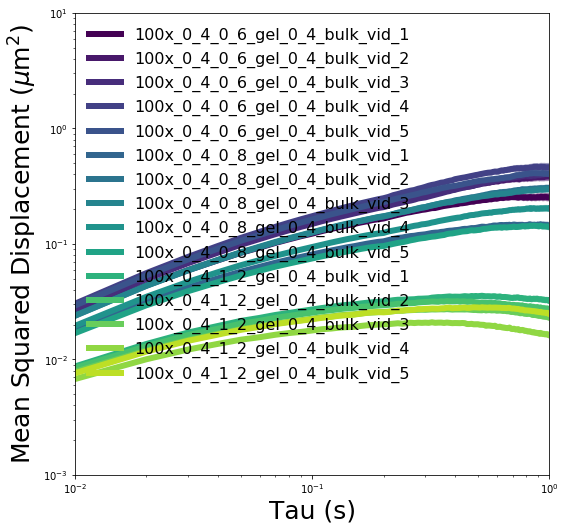

In [7]:
msd.plot_all_experiments(to_track[0:5]+to_track[10:15]+to_track[20:25], yrange=(10**-3, 10**1), bucket=bucket, folder=folder)

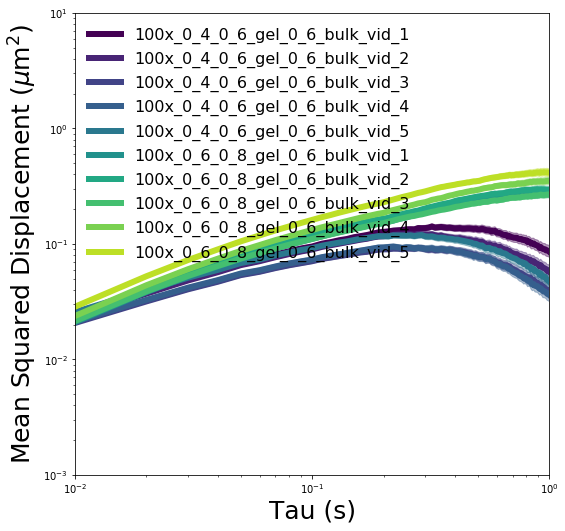

In [14]:
msd.plot_all_experiments(to_track[5:10] + to_track[30:35], yrange=(10**-3, 10**1), bucket=bucket, folder=folder)

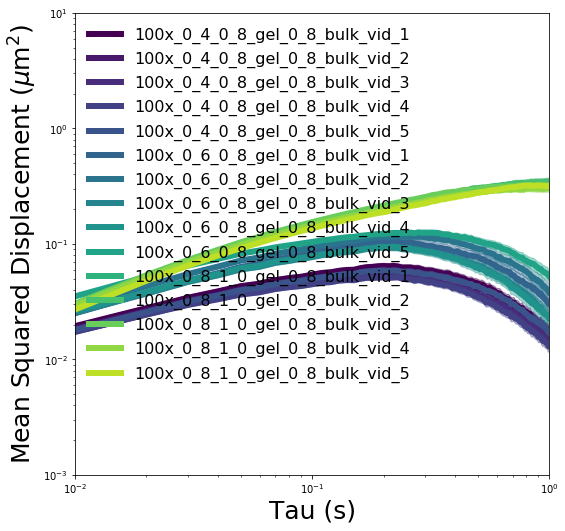

In [12]:
msd.plot_all_experiments(to_track[15:20] + to_track[35:45], yrange=(10**-3, 10**1), bucket=bucket, folder=folder)

In [ ]:
msd.plot_all_experiments(to_track[0:5]+to_track[10:15]+to_track[20:25], yrange=(10**-3, 10**1), bucket=bucket, folder=folder)

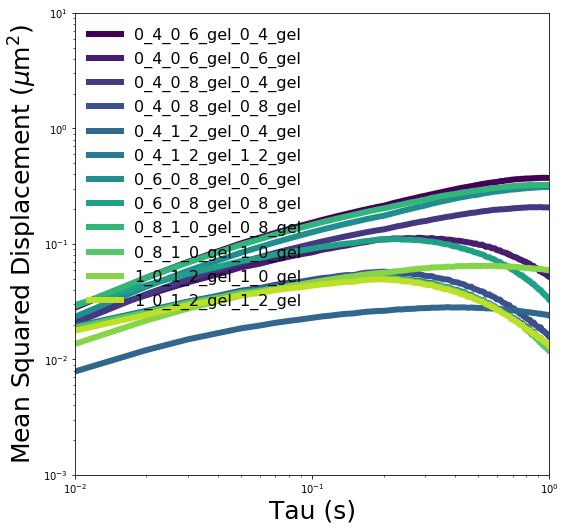

In [18]:
msd.plot_all_experiments(exps,
                         yrange=(10**-3, 10**1), bucket=bucket, folder=folder)

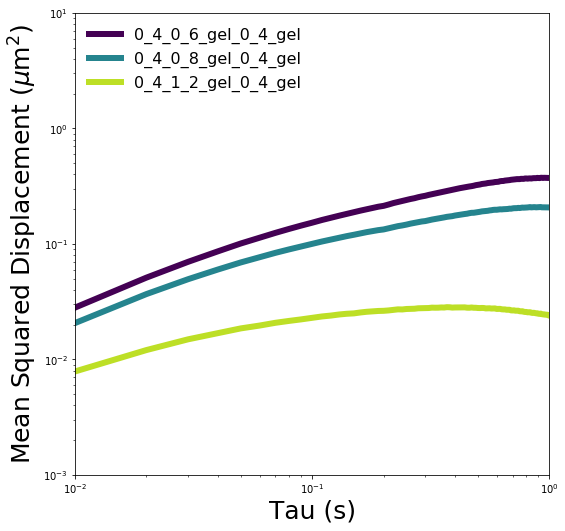

In [20]:
from operator import itemgetter
b = [0, 2, 4]
itemgetter(*b)(exps)
msd.plot_all_experiments(itemgetter(*b)(exps),
                         yrange=(10**-3, 10**1), bucket=bucket, folder=folder)

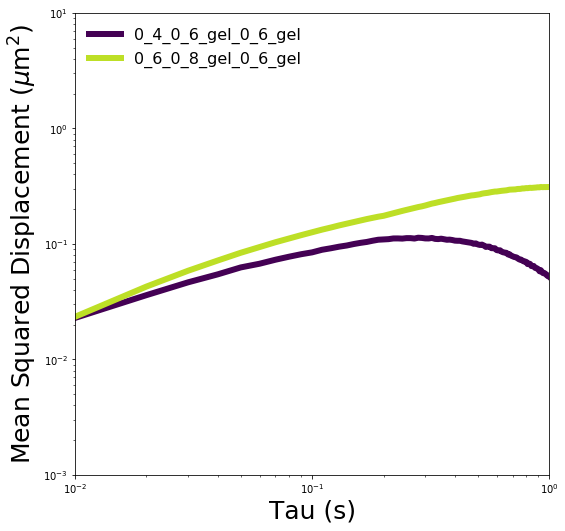

In [21]:
b = [1, 6]
itemgetter(*b)(exps)
msd.plot_all_experiments(itemgetter(*b)(exps),
                         yrange=(10**-3, 10**1), bucket=bucket, folder=folder)

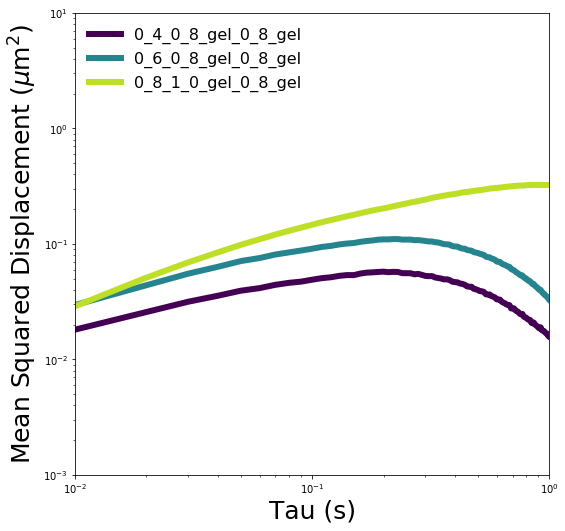

In [22]:
b = [3, 7, 8]
itemgetter(*b)(exps)
msd.plot_all_experiments(itemgetter(*b)(exps),
                         yrange=(10**-3, 10**1), bucket=bucket, folder=folder)

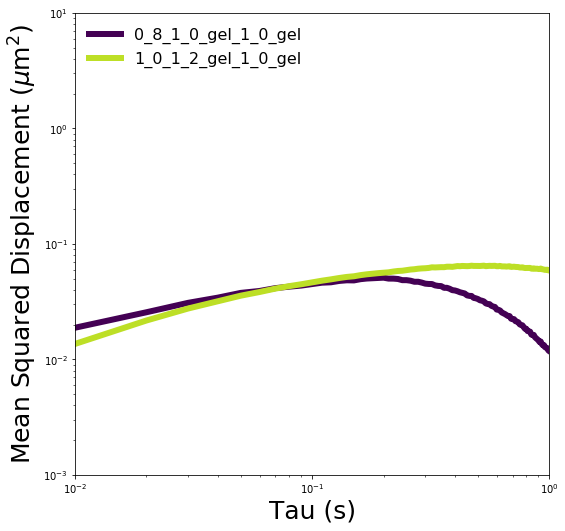

In [23]:
b = [9, 10]
itemgetter(*b)(exps)
msd.plot_all_experiments(itemgetter(*b)(exps),
                         yrange=(10**-3, 10**1), bucket=bucket, folder=folder)

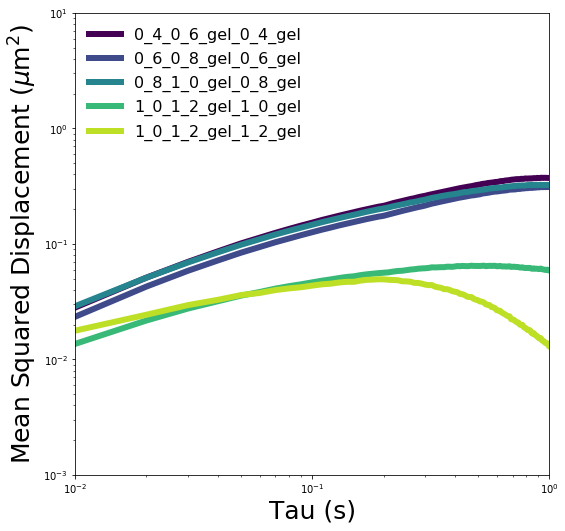

In [26]:
b = [0, 6, 8, 10, 11]
itemgetter(*b)(exps)
msd.plot_all_experiments(itemgetter(*b)(exps),
                         yrange=(10**-3, 10**1), bucket=bucket, folder=folder)

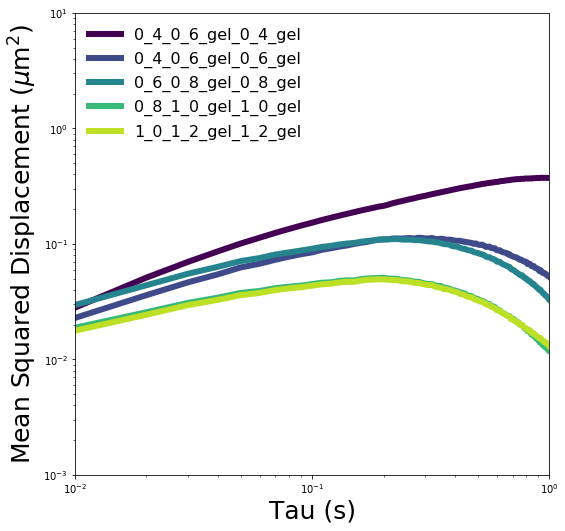

In [28]:
b = [0, 1, 7, 9, 11]
itemgetter(*b)(exps)
msd.plot_all_experiments(itemgetter(*b)(exps),
                         yrange=(10**-3, 10**1), bucket=bucket, folder=folder)

In [27]:
exps

['0_4_0_6_gel_0_4_gel',
 '0_4_0_6_gel_0_6_gel',
 '0_4_0_8_gel_0_4_gel',
 '0_4_0_8_gel_0_8_gel',
 '0_4_1_2_gel_0_4_gel',
 '0_4_1_2_gel_1_2_gel',
 '0_6_0_8_gel_0_6_gel',
 '0_6_0_8_gel_0_8_gel',
 '0_8_1_0_gel_0_8_gel',
 '0_8_1_0_gel_1_0_gel',
 '1_0_1_2_gel_1_0_gel',
 '1_0_1_2_gel_1_2_gel']

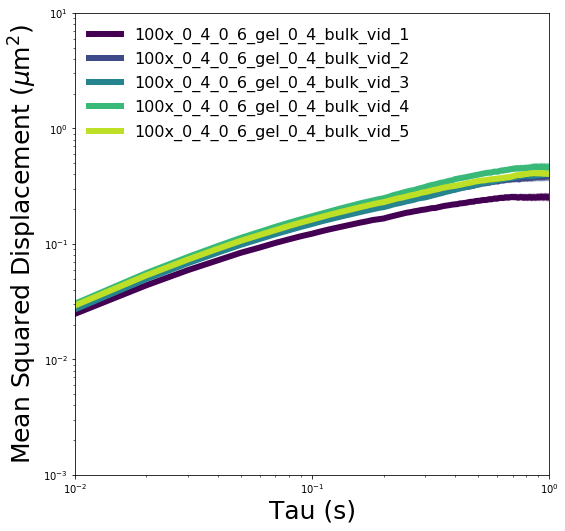

In [29]:
msd.plot_all_experiments(to_track[0:5], yrange=(10**-3, 10**1), bucket=bucket, folder=folder)

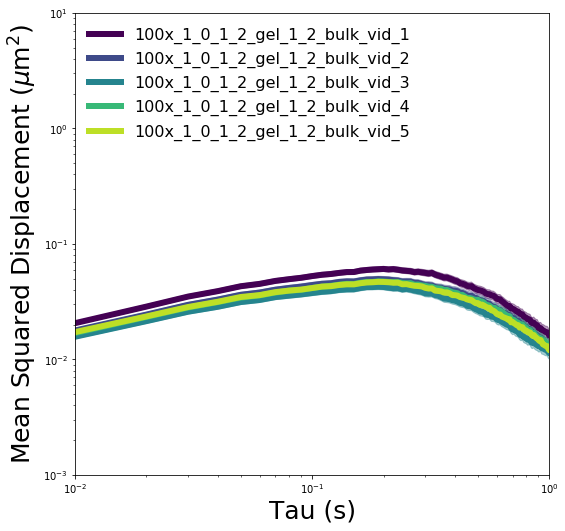

In [36]:
msd.plot_all_experiments(to_track[55:60], yrange=(10**-3, 10**1), bucket=bucket, folder=folder)